In [2]:
#!pip install numpy
#!pip install pandas
#!pip install plotly
#!pip install chemotools
#!pip install scipy
#!pip install scikit-learn
#!pip install Tensorflow
#!pip install Keras

In [1]:
def resumo(Ref_cal, Pred_cal, Ref_val, Pred_val):
    """
    Função para calcular as métricas de desempenho do modelo de regressão linear.
    Args:
        Ref_cal (array): Valores reais de calibração.
        Pred_cal (array): Valores previstos de calibração.
        Ref_val (array): Valores reais de validação.
        Pred_val (array): Valores previstos de validação.
    Returns:
        pd.DataFrame: DataFrame com as métricas de desempenho.
    """
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, r2_score
    from scipy.stats import iqr


    # Calculando R²
    R2_cal = r2_score(Ref_cal, Pred_cal)
    R2_val = r2_score(Ref_val, Pred_val)

    # Calculando RMMSE
    rmsec = np.sqrt(mean_squared_error(Ref_cal, Pred_cal))
    rmsep = np.sqrt(mean_squared_error(Ref_val, Pred_val))

    #Calculando rpd
    rpd = np.std(Ref_cal)/rmsep

    #Calculando RPIQ
    rpiq = iqr(Ref_val, rng=(25,75))/rmsep

    # Calculando Bias
    bias_pred = sum(Ref_val - Pred_val) / len(Pred_val)

    # Resumo do modelo
    resumo = pd.DataFrame([R2_cal, R2_val, rmsec, rmsep, rpd, rpiq, bias_pred]).T
    resumo.columns = ['R2_cal', 'R2_pred', 'RMSEC', 'RMSEP','RPD', 'RPIQ', 'Bias_pred']
    return resumo.round(3)

## **importando dados .csv com o pandas.read_csv**

In [4]:
import pandas as pd
Dataset = pd.read_csv('Dataset.csv', header=0, sep=';') #importando os dados

In [5]:
Atributos = Dataset.loc[:, ['SOC', 'CEC', 'pH', 'exMg', 'exP', 'exK', 'exCa']] #extraindo os atributos
Atributos.head(n=10) # mostra as 5 primeiras linhas do dataframe Y

,SOC,CEC,pH,exMg,exP,exK,exCa
0,18.89,11.90,5.2,1.68,24.2,0.56,4.32
1,16.24,11.76,5.6,2.01,12.1,0.38,5.10
2,23.18,13.28,5.5,2.30,17.7,0.20,5.82
3,14.64,10.71,5.2,1.60,5.5,0.10,3.67
4,22.98,13.13,4.6,1.48,21.6,0.30,3.60
5,15.38,11.15,4.4,0.94,11.8,0.14,2.87
6,26.72,14.59,5.4,2.96,27.2,0.35,6.32
7,14.99,11.59,4.9,1.93,9.7,0.10,3.80
8,23.41,14.09,4.7,2.17,39.9,0.30,4.42
9,14.84,12.10,4.5,1.43,9.0,0.12,3.35


## **kennard-stone**

In [6]:
# dividindo os dados via kennard-stone (mais recomendado)
import kennard_stone as ks

Ycal, Yval = ks.train_test_split(Atributos, test_size=0.3) # divide o dataframe Y em 70% para treino e 30% para teste

C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-19 12:31:15,420 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-19 12:31:15,429 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
# antes de começar, vamos utilizar os dados espectrais (com muitas variaveis) para fazer uma regressão PLS
pd.options.plotting.backend = 'plotly'

XRF = Dataset.loc[:,'1':'15'] 

# vamos utilizar a mesma separação de dados gerada no KS anterior para separar os espectros cal e val

XRFcal = XRF.loc[Ycal.index, :] # seleciona as linhas correspondentes as amostras de calibração
XRFval = XRF.loc[Yval.index, :] # seleciona os dados de validação

Ycal = Ycal.reset_index(drop=True) # reseta o índice do dataframe
Yval = Yval.reset_index(drop=True) # reseta o índice do dataframe 

In [8]:
# vamos pre-processar os dados com poisson scale + mean centering
import preprocessings as prepr
import numpy as np

XRFcal_prep, meanXRF, meanpoisson = prepr.poisson(XRFcal, mc=True) # aplica o preprocessamento 
XRFval_prep = (XRFval / np.sqrt(meanXRF)) - meanpoisson # aplica o mesmo preprocessamento nos dados de validação

In [9]:
#reprodutibilidade pelo TF
import os
import random
import tensorflow as tf

# Define um valor fixo para a semente
seed_value = 1

# 1. Configura a semente para o Python
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)

# 2. Configura a semente para o NumPy
np.random.seed(seed_value)

# 3. Configura a semente para o TensorFlow
tf.random.set_seed(seed_value)


## **Tensorflow (API Funcional)**
Pela API funcional vamos usar a estrategia de atribuir camadas a variaveis para construir arquiteturas personalizadas <br>
Ex:<br> 
**inputs** = keras.Input(shape=(37,)) <br>
**x** = keras.layers.Dense(32, activation="relu")**(inputs)** <br>
**outputs** = keras.layers.Dense(5, activation="softmax")**(x)** <br>
model = keras.Model(inputs=**inputs**, outputs=**outputs**)<br>
**Documentação**<br>
[API model class](https://keras.io/api/models/model/)<br>
[Camadas](https://keras.io/api/layers/)

In [10]:
#%pip install tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow as tf
import keras

input_size = XRFcal_prep.shape[1] # extraindo dimensão dos dados de entrada (número de variáveis espectrais)

# montando o modelo (ou empilhando as camadas)
input_layer = Input(shape=(input_size,), name='Input')
Dense1 = Dense(units=150, activation='relu', input_shape=(input_size,))(input_layer) # a primeira camada deve conter o input shape, que indica o número de variáveis espectrais
Drop1 = Dropout(0.25)(Dense1) # Dropout layer para prevenir overfitting trocar para 0.3 dps para ser didatico
Dense2 = Dense(units=130, activation='relu')(Drop1)
Drop2 = Dropout(0.25)(Dense2) # Dropout layer para prevenir overfitting
Dense3 = Dense(units=110, activation='relu')(Drop2)
Drop3 = Dropout(0.2)(Dense3) # Dropout layer para prevenir overfitting
Dense4 = Dense(units=90, activation='relu')(Drop3)
Drop4 = Dropout(0.2)(Dense4) # Dropout layer para prevenir overfitting
Dense5 = Dense(units=70, activation='relu')(Drop4)
Dense6 = Dense(units=50, activation='relu')(Dense5)
Dense7 = Dense(units=30, activation='relu')(Dense6)
Dense8 = Dense(units=10, activation='relu')(Dense7)
Output = Dense(units=1, activation='linear')(Dense8) # a última camada deve conter o número de variáveis de resposta

# montando o modelo através da API funcional do Keras
mlptf = Model(inputs=input_layer, outputs=Output) 
mlptf.summary()

C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 701)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       105,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 130)            │        19,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 110)            │        14,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         9,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 70)             │         6,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,101 (629.30 KB)

 Trainable params: 161,101 (629.30 KB)

 Non-trainable params: 0 (0.00 B)

O processo de treino e predição continua o mesmo <br> 
Compila o modelo antes do treino, configurando **loss**, **optimizer** e **metrics** em **model.compile()**<br>
Depois faz o **.fit()** e, por fim, o **.predict()** se quiser prever novos dados<br>
OBS: tem como incorporar a validação já dentro do **.fit** (facilita)<br>
Documentação<br>
[Compile](https://keras.io/api/models/model_training_apis/)<br>
[Funções de Loss](https://keras.io/api/losses/)<br>
[Metricas](https://keras.io/api/metrics/)<br>
[Otimizadores](https://keras.io/api/optimizers/)
[fit](https://keras.io/api/models/model_training_apis/)

## **Early stopping**
---
**keras**.**callbacks**.**EarlyStopping**(**monitor**="val_loss",
    **min_delta**=0,
    **patience**=0,
    **verbose**=0,
    **mode**="auto",
    **baseline**=None,
    **restore_best_weights**=False,
    start_from_epoch=0,
)<br>

**Argumentos**<br>
<br>
**monitor**: Quantidade a ser monitorada. O padrão é "val_loss" <br>
**min_delta**: Alteração mínima na quantidade monitorada para se qualificar como uma melhoria, ou seja, uma alteração absoluta menor que min_delta, contará como nenhuma melhoria. O padrão é 0. <br>
**patience**: Número de épocas sem melhoria após os quais o treinamento será interrompido. O padrão é 0. <br>
**verbose**: Modo de verbosidade, 0 ou 1. O modo 0 é silencioso e o modo 1 exibe mensagens quando o retorno de chamada realiza uma ação. O padrão é 0. <br>
**mode**: {"auto", "min", "max"}. No modo min, o treinamento será interrompido quando a quantidade monitorada parar de diminuir; no modo "max", ele será interrompido quando a quantidade monitorada parar de aumentar; no modo "auto", a direção é inferida automaticamente a partir do nome da quantidade monitorada. O padrão é "auto".<br>
**baseline**: Valor da linha de base para a quantidade monitorada. Caso contrário, o treinamento será interrompido se o modelo não apresentar melhoria em relação à linha de base. O padrão é Nenhum.<br>
**restore_best_weights**: Se os pesos do modelo devem ser restaurados da época com o melhor valor da quantidade monitorada. Se Falso, os pesos do modelo obtidos na última etapa do treinamento são usados. Uma época será restaurada independentemente do desempenho em relação à linha de base. Se nenhuma época melhorar em relação à linha de base, o treinamento será executado para épocas de paciência e restaurará os pesos da melhor época naquele conjunto. O padrão é Falso.<br>
**start_from_epoch**: Número de épocas a aguardar antes de começar a monitorar a melhoria. Isso permite um período de aquecimento no qual nenhuma melhoria é esperada e, portanto, o treinamento não será interrompido. O padrão é 0.

Quando você chama **model.fit(...)**, o Keras automaticamente registra um **callback History** que armazena, a cada época, valores de loss e métricas (incluindo validação, se houver) num dicionário history.history. Podemos usa-lo para monitorar o modelo. 

In [11]:
# compilando o modelo
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # gerando a função de erro RMSE

# Principais losses = 'mean_squared_error' e 'mean_absolute_error'
# Principais otimizadores = 'Adam', 'SGD', 'RMSprop'
# Principais métricas = 'mae', 'mse', 'rmse', 'r2_score'

# implementando o earlstopping para definir um criterio de parada
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    # prefixo "val_" para validação, caso contrario ele atua no treino (val_r2_score para o r2_score da validação por exemplo)
    mode='min',                # queremos minimizar o erro de validação
    patience=20,             # número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True,
    verbose=1)                  # para ver quando o callback aciona

mlptf.compile(optimizer='Adam', loss=rmse, metrics=['r2_score']) # compila o modelo, definindo o otimizador, a função de erro e as métricas que serão utilizadas para avaliar o desempenho do modelo

historico_mlptf = mlptf.fit(x=XRFcal_prep,
                       y=Ycal['exCa'],
                       epochs=50,
                       batch_size=10,  # o batch_size é o lote amostras que serão usadas para calcular o gradiente e atualizar os pesos do modelo, em outras palavras, =10 significa que de 10 em 10 amostras o modelo atualiza os pesos (frequencia de atualização dos pesos)
                       validation_data=(XRFval_prep, Yval['exCa']), # o conjunto de validação é utilizado para monitorar o desempenho do modelo durante o treinamento e evitar overfitting.
                       callbacks=[early_stopping],
                       verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.3790 - r2_score: -5.1334 - val_loss: 1.2895 - val_r2_score: 0.4959
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0009 - r2_score: -0.2421 - val_loss: 0.9019 - val_r2_score: 0.7587
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5797 - r2_score: 0.1986 - val_loss: 1.0687 - val_r2_score: 0.6660
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3510 - r2_score: 0.4588 - val_loss: 1.1008 - val_r2_score: 0.6454
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2781 - r2_score: 0.4925 - val_loss: 0.8495 - val_r2_score: 0.7864
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1676 - r2_score: 0.5842 - val_loss: 0.8709 - val_r2_score: 0.7749
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1745 - r2_score: 0.5784 - val_loss: 0.9502 - val_r2_score: 0.7365
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0444 - r2_score: 0.6455 - val_loss: 0.9625 - val_r2_scor

Para utilizar o modelo em novos dados, novamente analogo ao sklearn, utilizamos o **model.predict**

In [12]:
# Resultados de calibração e predição por meio do comando predict()
calres_mlptf = pd.DataFrame({'Ref': Ycal['exCa'], 'Pred': mlptf.predict(XRFcal_prep).flatten()})

# resultados de validação
predres_mlptf = pd.DataFrame({'Ref': Yval['exCa'], 'Pred': mlptf.predict(XRFval_prep).flatten()})

# extraindo metricas de desempenho do modelo
resumo_mlptf = resumo(calres_mlptf['Ref'], calres_mlptf['Pred'], predres_mlptf['Ref'], predres_mlptf['Pred']).T # calcula o resumo para os dados de calibração
resumo_mlptf

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,0
R2_cal,0.904
R2_pred,0.879
RMSEC,0.592
RMSEP,0.658
RPD,2.905
RPIQ,4.544
Bias_pred,0.024


In [13]:
resultados_mlptf= pd.concat([calres_mlptf, predres_mlptf], axis=0).reset_index(drop=True) # junta os dataframes de calibração e validação
resultados_mlptf.insert(0, 'Grupo', ['Cal'] * len(Ycal) + ['Val'] * len(Yval)) # insere uma coluna com o grupo (calibração ou validação) no dataframe de previsões

import plotly.express as px
#plot de dispersão
fig = px.scatter(resultados_mlptf,
                 x='Ref',
                 y='Pred',
                 color='Grupo',
                 color_discrete_sequence=['red', 'blue'])
fig.show()

In [14]:
#reprodutibilidade pelo TF
import os
import random
import tensorflow as tf

# Define um valor fixo para a semente
seed_value = 1

# 1. Configura a semente para o Python
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)

# 2. Configura a semente para o NumPy
np.random.seed(seed_value)

# 3. Configura a semente para o TensorFlow
tf.random.set_seed(seed_value)

## **MLP multi-target (SOC e exCa)**

In [15]:
Ycal=Ycal[['SOC', 'exCa']] # seleciona apenas as colunas SOC e exCa 
Yval=Yval[['SOC', 'exCa']]

In [16]:
# Definindo o modelo multi-target para quantificar SOC e exCa com a API funcional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

Input_size = XRFcal_prep.shape[1] # extraindo dimensão dos dados de entrada (número de variáveis espectrais)

Camada_input = Input(shape=(Input_size,))
Camada_comum1 = Dense(units=512, activation='relu')(Camada_input)
Camada_comum2 = Dropout(0.3)(Camada_comum1)  # Dropout layer para prevenir overfitting
Camada_comum3 = Dense(units=256, activation='relu')(Camada_comum2)
Camada_comum4 = Dropout(0.2)(Camada_comum3)  # Dropout layer para prevenir overfitting

# Camada SOC
Camada_SOC1 = Dense(units=256, activation='relu', name='Dense_SOC1')(Camada_comum4)
Camada_SOC2 = Dropout(0.2)(Camada_SOC1)  # Dropout Camada para prevenir overfitting
Camada_SOC3 = Dense(units=128, activation='relu')(Camada_SOC2)
Camada_SOC4 = Dropout(0.1)(Camada_SOC3)  # Dropout Camada para prevenir overfitting
Camada_SOC5 = Dense(units=64, activation='relu')(Camada_SOC4)
Output_SOC = Dense(units=1, activation='linear', name='SOC_output')(Camada_SOC5)  # a última camada deve conter o número de variáveis de resposta

# Camada exCa
Camada_exCa1 = Dense(units=256, activation='relu')(Camada_comum4)
Camada_exCa2 = Dropout(0.3)(Camada_exCa1)  # Dropout layer para prevenir overfitting
Camada_exCa3 = Dense(units=128, activation='relu')(Camada_exCa2)
Camada_exCa4 = Dropout(0.2)(Camada_exCa3)  # Dropout layer para prevenir overfitting
Camada_exCa5 = Dense(units=64, activation='relu')(Camada_exCa4)
Output_exCa = Dense(units=1, activation='linear', name='exCa_output')(Camada_exCa5)  # a última camada deve conter o número de variáveis de resposta

mlp_mt = Model(inputs=Camada_input, outputs=[Output_SOC, Output_exCa])
mlp_mt.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 701)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    359,424 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_SOC1 (Dense)  │ (None, 256)       │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ Dense_SOC1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOC_output (Dense)  │ (None, 1)         │         65 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exCa_output (Dense) │ (None, 1)         │         65 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 704,770 (2.69 MB)

 Trainable params: 704,770 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

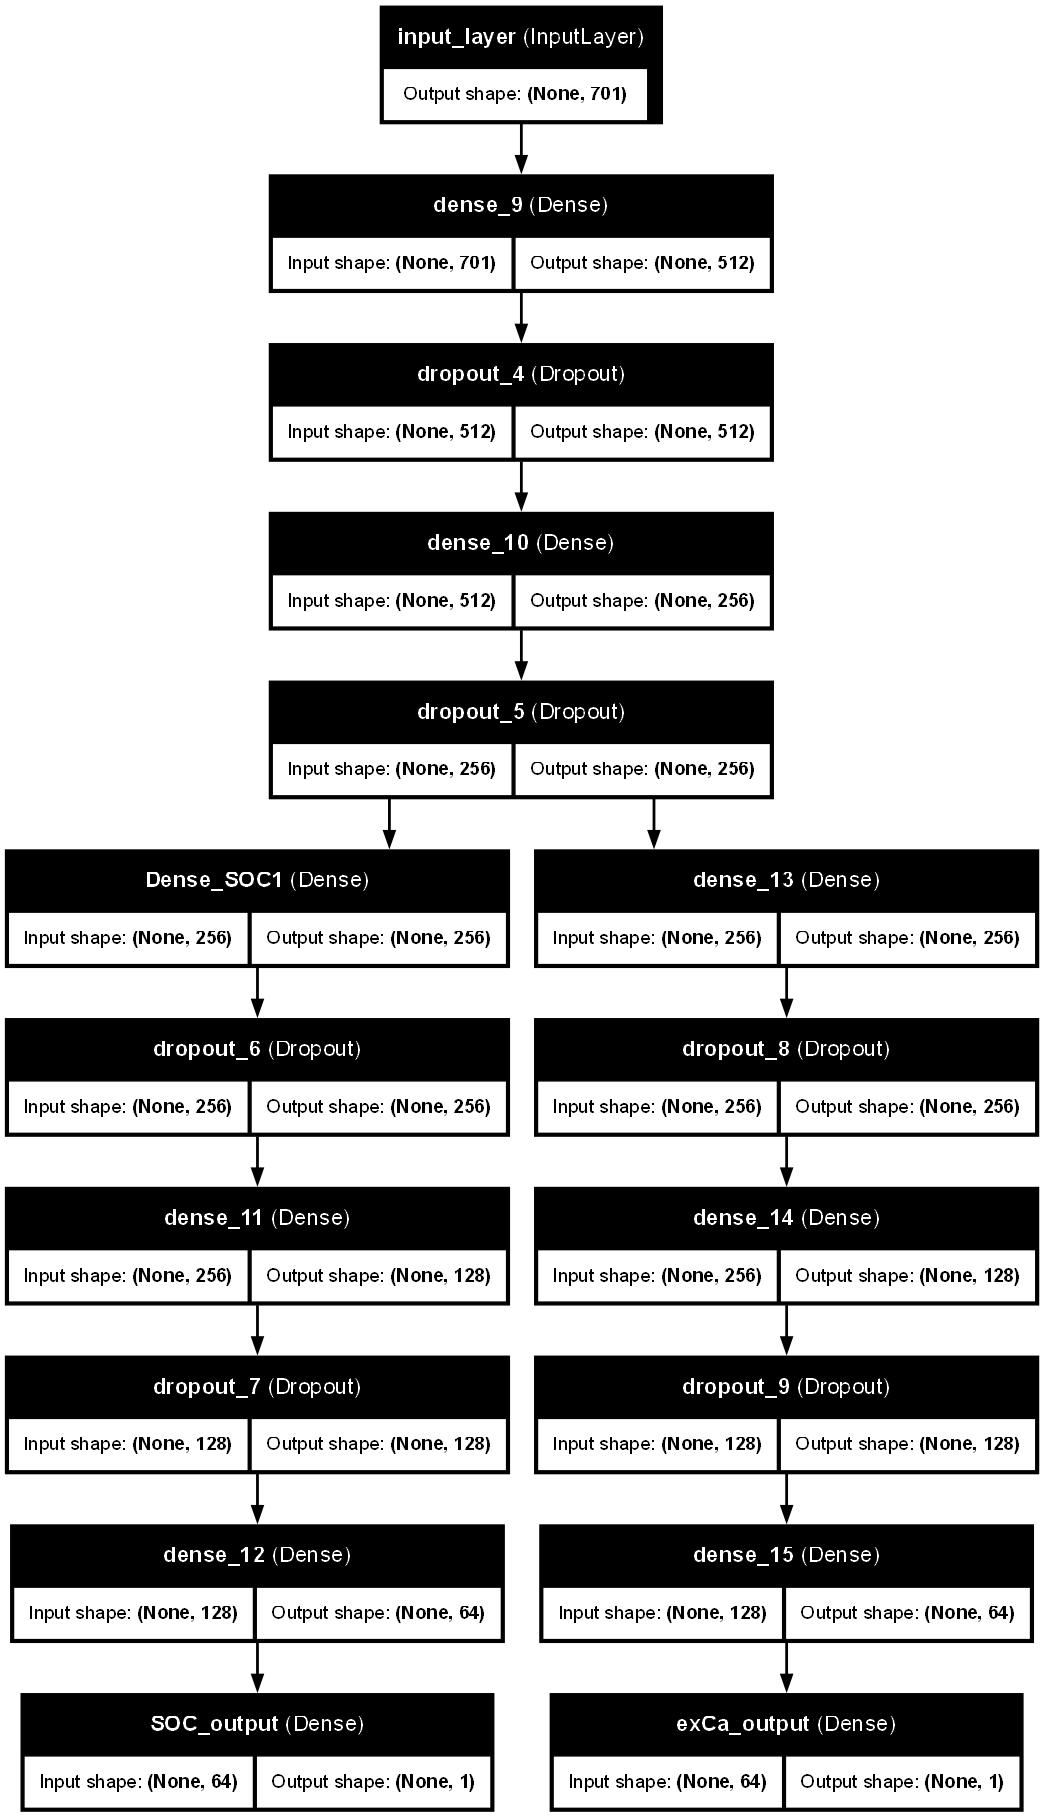

In [17]:
import keras
keras.utils.plot_model(mlp_mt, "mlp_mt.png", show_shapes=True, show_layer_names=True, dpi=100, rankdir="TB")  #ou rankidir="LR"     


In [18]:
# preparando os dados de calibração e validação atraves de dicionários
Ycal_dict = {
      'SOC_output': Ycal['SOC'],
      'exCa_output': Ycal['exCa']
}

Yval_dict = {
      'SOC_output': Yval['SOC'],
      'exCa_output': Yval['exCa']
}

In [19]:
mlp_mt.compile(optimizer='Adam', 
               loss={'SOC_output': rmse,
                     'exCa_output': rmse},
             metrics={
                 'SOC_output': ['r2_score'],
                 'exCa_output': ['r2_score']})


early_stopping = EarlyStopping(
    monitor='val_loss',    # prefixo "val_" para validação, caso contrario ele atua no treino (val_r2_score para o r2_score da validação por exemplo)
    mode='min',                # queremos minimizar o erro de validação
    patience=20,             # número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True,
    verbose=1)                  # para ver quando o callback aciona

mlp_mt_historico = mlp_mt.fit(XRFcal_prep, 
                    Ycal_dict, 
                    epochs=40, 
                    batch_size=20, # o batch_size é o numero de amostras que serão incorporadas no erro medio para atualizar os pesos do modelo. se = 10, a cada 10 amostras o modelo atualiza os pesos
                    callbacks=[early_stopping], # aplica o early stopping
                    validation_data=(XRFval_prep, Yval_dict),
                    verbose=1)  


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - SOC_output_loss: 15.6716 - SOC_output_r2_score: -7.8179 - exCa_output_loss: 3.9778 - exCa_output_r2_score: -4.0537 - loss: 19.6580 - val_SOC_output_loss: 5.3521 - val_SOC_output_r2_score: -0.2443 - val_exCa_output_loss: 1.7105 - val_exCa_output_r2_score: 0.2595 - val_loss: 6.3940
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - SOC_output_loss: 7.1035 - SOC_output_r2_score: -0.7047 - exCa_output_loss: 2.0458 - exCa_output_r2_score: -0.2130 - loss: 9.1532 - val_SOC_output_loss: 4.6177 - val_SOC_output_r2_score: 0.0115 - val_exCa_output_loss: 1.3168 - val_exCa_output_r2_score: 0.5445 - val_loss: 5.5659
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - SOC_output_loss: 6.4164 - SOC_output_r2_score: -0.3813 - exCa_output_loss: 1.8000 - exCa_output_r2_score: 0.0564 - loss: 8.2203 - val_SOC_output_loss: 4.3992 - val_SOC_output_r2_score: 0.1340 - val_exCa_output_loss: 1.1804 - val_exCa_output_r2_score: 0.6558 - val_loss: 5.1144
Epoch

In [20]:
# função para calcular as métricas de desempenho dos modelos multi-target

def resumo_multitarget(df: pd.DataFrame):
    import numpy as np
    import pandas as pd
    from scipy.stats import iqr
    from sklearn.metrics import mean_squared_error, r2_score
    """
    Calcula métricas de desempenho para pares de colunas de um DataFrame.
    
    - Suporta qualquer DataFrame cujas colunas estejam organizadas em pares:
      [ref1, pred1, ref2, pred2, ..., refN, predN].
    - Retorna um dict com as chaves: 'R2', 'r2', 'RMSE', 'RPIQ', 'Bias', 't_bias'.
      Cada uma delas mapeia o nome da coluna de predição ao valor da métrica.
    """
    cols = df.columns.tolist()
    n_cols = len(cols)
    if n_cols % 2 != 0:
        raise ValueError("DataFrame deve ter número par de colunas (ref × pred).")
    
    metrics = {
        'R2':   {},
        'r2':   {},
        'RMSE': {},
        'RPIQ': {},
        'Bias': {},
        't_bias': {}
    }
    
    n = df.shape[0]
    for i in range(0, n_cols, 2):
        ref = cols[i]
        pred = cols[i+1]
        y_ref = df[ref].values
        y_pred = df[pred].values
        
        # 1) Coeficiente de determinação (sklearn)
        metrics['R2'][pred] = r2_score(y_ref, y_pred)
        # 2) r² via correlação de Pearson
        corr = np.corrcoef(y_ref, y_pred)[0,1]
        metrics['r2'][pred] = corr**2
        # 3) RMSE
        rmse = np.sqrt(mean_squared_error(y_ref, y_pred))
        metrics['RMSE'][pred] = rmse
        # 4) RPIQ = IQR(y_ref) / RMSE
        iqr_val = iqr(y_ref, rng=(25,75))
        metrics['RPIQ'][pred] = iqr_val / rmse if rmse != 0 else np.nan
        # 5) Bias
        bias = np.mean(y_ref - y_pred)
        metrics['Bias'][pred] = bias
        # 6) t-bias: |bias| * sqrt(n) / SDV, SDV = std dos erros (ddof=1)
        errors = y_ref - y_pred
        sdv = np.std(errors - bias, ddof=1)
        metrics['t_bias'][pred] = (abs(bias) * np.sqrt(n) / sdv) if sdv != 0 else np.nan
    
    return metrics

In [21]:
# transformando os resultados em dataframes
calres_mlp_mt = pd.DataFrame({
	'SOC': mlp_mt.predict(XRFcal_prep)[0].flatten(), # predição dos dados de calibração,
	'exCa': mlp_mt.predict(XRFcal_prep)[1].flatten() # predição dos dados de calibração
})
predres_mlp_mt = pd.DataFrame({
	'SOC': mlp_mt.predict(XRFval_prep)[0].flatten(), # predição dos dados de validação
	'exCa': mlp_mt.predict(XRFval_prep)[1].flatten() # predição dos dados de validação
})

# inserindo os dados de referência nos dataframes
# A função enumerate() em Python é usada para percorrer uma sequência (como uma lista, tupla, string, etc.) e, ao mesmo tempo, obter tanto o índice como o valor de cada elemento.
# Nesse caso ela extrai o índice e o nome da coluna do dataframe Ycal e Yval simultaneamente

for i, col in enumerate(Ycal.columns):
    calres_mlp_mt.insert(i * 2, f"Ref_{col}", Ycal[col])
    
for i, col in enumerate(Yval.columns):
    predres_mlp_mt.insert(i * 2, f"Ref_{col}", Yval[col])	

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [22]:
# extraindo as métricas de desempenho do modelo multi-target
resumo_mlp_mt = {'Cal': pd.DataFrame(resumo_multitarget(calres_mlp_mt)),
                 'Pred': pd.DataFrame(resumo_multitarget(predres_mlp_mt))}

In [23]:
#printando as metricas 
print("R2 Calibração:")
for key, value in resumo_mlp_mt['Cal']['R2'].items():
    print(f"{key}: {value}")

print("\nR2 Predição:")
for key, value in resumo_mlp_mt['Pred']['R2'].items():
    print(f"{key}: {value}")

print("\nRMSEC:")
for key, value in resumo_mlp_mt['Cal']['RMSE'].items():
    print(f"{key}: {value}")  

print("\nRMSEP:")
for key, value in resumo_mlp_mt['Pred']['RMSE'].items():
    print(f"{key}: {value}")  

print("\nRPIQ:")
for key, value in resumo_mlp_mt['Pred']['RPIQ'].items():
    print(f"{key}: {value}")  

R2 Calibração:
SOC: 0.8024736062324056
exCa: 0.8104783428701099

R2 Predição:
SOC: 0.5140703607721178
exCa: 0.8492472663290808

RMSEC:
SOC: 2.4250848693587193
exCa: 0.8321130360034934

RMSEP:
SOC: 3.036774029183854
exCa: 0.7350124598723431

RPIQ:
SOC: 2.0910347424522033
exCa: 4.067958250012936


## **CNN 1D**

In [24]:
#reprodutibilidade pelo TF
import os
import random
import tensorflow as tf

# Define um valor fixo para a semente
seed_value = 1

# 1. Configura a semente para o Python
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)

# 2. Configura a semente para o NumPy
np.random.seed(seed_value)

# 3. Configura a semente para o TensorFlow
tf.random.set_seed(seed_value)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

Input_size = XRFcal_prep.shape[1] # extraindo dimensão dos dados de entrada (número de variáveis espectrais)

# Definindo o modelo com a API funcional

Camada_input = Input(shape=(Input_size,1), name='Input')
Conv1 = Conv1D(filters=16, kernel_size=5, activation='relu')(Camada_input)
MaxP1 = MaxPooling1D(pool_size=2, strides=2)(Conv1)
Conv2 = Conv1D(filters=32, kernel_size=5, activation='relu')(MaxP1)
MaxP2 = MaxPooling1D(pool_size=2, strides=2)(Conv2)
Conv3 = Conv1D(filters=64, kernel_size=5, activation='relu')(MaxP2)
MaxP3 = MaxPooling1D(pool_size=2, strides=2)(Conv3)
Dropout1 = Dropout(0.2)(MaxP3)  # Dropout layer para prevenir overfitting
Camada_flatten = Flatten()(Dropout1)  # Flatten layer para converter a saída 3D em 1D
Dense1 = Dense(units=256, activation='relu')(Camada_flatten)
Dense2 = Dropout(0.15)(Dense1)  # Dropout layer para prevenir overfitting
Dense3 = Dense(units=128, activation='relu')(Dense2)
Dropout2 = Dropout(0.1)(Dense3)  # Dropout layer para prevenir overfitting
Dense5 = Dense(units=64, activation='relu')(Dropout2)
output_exCa = Dense(units=1, activation='linear')(Dense5)  # a última camada deve conter o número de variáveis de resposta

cnn1d = Model(inputs=Camada_input, outputs=[output_exCa])
cnn1d.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 701, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 697, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 348, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 344, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 172, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 168, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     1,376,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,430,721 (5.46 MB)

 Trainable params: 1,430,721 (5.46 MB)

 Non-trainable params: 0 (0.00 B)

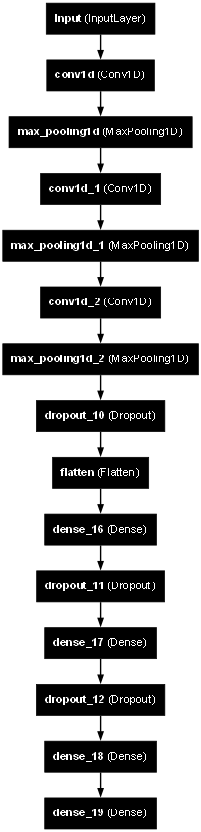

In [26]:
import keras
keras.utils.plot_model(cnn1d, "cnn1d.png", show_shapes=False, show_layer_names=True, dpi=50, rankdir="TB")  # TB ou rankidir="LR"     


In [27]:
# compilando o modelo
early_stopping = EarlyStopping(
    monitor='val_loss',    # prefixo "val_" para validação, caso contrario ele atua no treino (val_r2_score para o r2_score da validação por exemplo)
    mode='min',                # queremos minimizar o erro de validação
    patience=20,             # número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True,
    verbose=1)                  # para ver quando o callback aciona

cnn1d.compile(optimizer='Adam', loss=rmse, metrics=['r2_score']) # compila o modelo, definindo o otimizador, a função de erro e as métricas que serão utilizadas para avaliar o desempenho do modelo

cnn1d_historico = cnn1d.fit(x=XRFcal_prep,
                       y=Ycal['exCa'],
                       epochs=50,
                       batch_size=10,  # o batch_size é o lote amostras que serão usadas para calcular o gradiente e atualizar os pesos do modelo, em outras palavras, =10 significa que de 10 em 10 amostras o modelo atualiza os pesos (frequencia de atualização dos pesos)
                       validation_data=(XRFval_prep, Yval['exCa']), # o conjunto de validação é utilizado para monitorar o desempenho do modelo durante o treinamento e evitar overfitting.
                       callbacks=[early_stopping],
                       verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.0639 - r2_score: -2.5323 - val_loss: 1.1029 - val_r2_score: 0.6440
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.1975 - r2_score: 0.5690 - val_loss: 0.8726 - val_r2_score: 0.7741
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0352 - r2_score: 0.6803 - val_loss: 0.7605 - val_r2_score: 0.8305
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0268 - r2_score: 0.6805 - val_loss: 0.8844 - val_r2_score: 0.7655
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.9568 - r2_score: 0.7198 - val_loss: 0.6817 - val_r2_score: 0.8606
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.9749 - r2_score: 0.7081 - val_loss: 0.8830 - val_r2_score: 0.7645
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0861 - r2_score: 0.6349 - val_loss: 0.7291 - val_r2_score: 0.8369
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.9196 - r2_score: 0.7475 - val_loss: 0.6926 - val_

In [28]:
# Resultados de calibração e predição por meio do comando predict()
calres_cnn1d = pd.DataFrame({'Ref': Ycal['exCa'], 'Pred': cnn1d.predict(XRFcal_prep).flatten()})

# resultados de validação
predres_cnn1d = pd.DataFrame({'Ref': Yval['exCa'], 'Pred': cnn1d.predict(XRFval_prep).flatten()})

# extraindo metricas de desempenho do modelo
resumo_cnn1d = resumo(calres_cnn1d['Ref'], calres_cnn1d['Pred'], predres_cnn1d['Ref'], predres_cnn1d['Pred']).T # calcula o resumo para os dados de calibração
resumo_cnn1d

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,0
R2_cal,0.917
R2_pred,0.891
RMSEC,0.549
RMSEP,0.625
RPD,3.056
RPIQ,4.781
Bias_pred,-0.021


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# ------------------------------------------------------------------
# 1) Cria um modelo auxiliar que retorna a saída da primeira Conv1D
# ------------------------------------------------------------------

# Obtém o nome da primeira camada Conv1D na arquitetura cnn1d
cnn1d_layer = cnn1d.layers[1].name  # aqui assumimos que layers[0] é a camada de Input

feature_extractor = Model(
    inputs=cnn1d.input,
    outputs=cnn1d.get_layer(cnn1d_layer).output)
# Define um novo modelo Keras “feature_extractor”:
#   inputs=cnn1d.input
#       — especifica que ele recebe as mesmas entradas que o modelo original
#   outputs=cnn1d.get_layer(cnn1d_layer).output
#       — especifica que sua saída será a ativação dessa camada Conv1D em particular

# ------------------------------------------------------------------
# 2) Prepara um exemplo de entrada no formato que a rede espera
# ------------------------------------------------------------------

x_sample = XRFcal_prep.iloc[0].values.reshape(1, Input_size, 1)
# Seleciona a primeira linha de XRFcal_prep (pandas DataFrame)
# .iloc[0,].values retorna os valores como um array NumPy 1D
# reshape(1, Input_size, 1) muda o formato para:
#   • 1 exemplo
#   • Input_size variaveis espectrais
#   • 1 canal (já que é Conv1D)

# ------------------------------------------------------------------
# 3) Gera os feature maps passando o exemplo pelo feature_extractor
# ------------------------------------------------------------------

feature_maps = feature_extractor.predict(x_sample)
# feature_maps terá shape (1, new_width, 16),
# onde new_width é o tamanho de saída da Conv1D e 16 é o número de filtros

# ------------------------------------------------------------------
# 4) Prepara o vetor de “energias” para usar como eixo X nos plots
# ------------------------------------------------------------------

energies = np.array(
    XRFcal_prep.columns[:feature_maps.shape[1]],
    dtype=float)
# Converte os nomes das colunas (strings) em floats de energia (keV)
# Aqui cortamos para feature_maps.shape[1] valores, garantindo alinhamento

# ------------------------------------------------------------------
# 5) Configura o layout de figuras para visualizar todos os filtros
# ------------------------------------------------------------------

n_filters = feature_maps.shape[-1]
# n_filters = número de filtros da camada (última dimensão do feature_maps)

n_rows, n_cols = 4, 4
# Queremos um grid 4×4 (para até 16 filtros)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(18, 16),
    sharex=False,
    sharey=False)
# Cria uma figura com subplots organizados em 4 linhas × 4 colunas
# figsize define o tamanho total em polegadas
# sharex/sharey=False garante eixos independentes em cada plot

# ------------------------------------------------------------------
# 6) Itera sobre cada filtro para desenhar seu feature map
# ------------------------------------------------------------------

# recaptulando 
# n_filters = número de filtros (total de feature maps)
# n_rows, n_cols = número de linhas e colunas do grid de subplots
# fig, axes = plt.subplots(n_rows, n_cols, ...)

# Itera sobre cada filtro, numerados de 0 até n_filters-1
for idx in range(n_filters):

    # range(n_filters) gera a sequência de inteiros 0, 1, 2, …, n_filters-1
    # row e col determinam a posição no grid:
    # Usamos divisão inteira (operator `//`) para definir a linha
    row = idx // n_cols
    # • `idx // n_cols` divide idx por n_cols e arredonda
    #   o resultado para baixo.
    # • Exemplo: se n_cols = 4,
    #     idx = 0 → 0 // 4 = 0  (linha 0)
    #     idx = 1 → 1 // 4 = 0  (linha 0)
    #     idx = 2 → 2 // 4 = 0  (linha 0)
    #     idx = 3 → 3 // 4 = 0  (linha 0)
    #     idx = 4 → 4 // 4 = 1  (linha 1)
    #   Assim, cada bloco de 4 índices avança uma linha.

    # Usamos o operador resto de divisao (operator `%`) para definir a coluna:
    col = idx % n_cols
    # • `idx % n_cols` retorna o resto da divisão de idx por n_cols.
    # • Exemplo: se n_cols = 4,
    #     idx = 0 → 0 % 4 = 0  (coluna 0)
    #     idx = 1 → 1 % 4 = 1  (coluna 1)
    #     idx = 2 → 2 % 4 = 2  (coluna 2)
    #     idx = 3 → 3 % 4 = 3  (coluna 3)
    #     idx = 4 → 4 % 4 = 0  (volta a coluna 0 na próxima linha)
    #   Assim, o resto “reseta” o contador de colunas quando

    # Agora selecionamos o eixo correto no grid de subplots para a figura especificada:
    ax = axes[row, col]

    ax.plot(
        energies,
        feature_maps[0, :, idx],
        linewidth=1.0)
    # Plota uma linha com:
    #   • x = energias (keV)
    #   • y = ativações do filtro idx ao longo do eixo new_width
    # feature_maps tem shape (1, new_width, n_filters), então acessamos:
    #   feature_maps[0, :, idx]


    # Define título e rótulos para tornar o gráfico didático
    ax.set_title(f'Feature map {idx}')
    ax.set_xlabel('Energia (keV)')
    ax.set_ylabel('Ativação')

    # Ajusta ticks de X de 2 em 2 (se fizer sentido para your range)
    ax.set_xticks(np.arange(energies.min(), energies.max()+1, 2))

    # Define limites do eixo X de 1 a 15 keV (ajuste conforme seu caso)
    ax.set_xlim(1, 15)

# ------------------------------------------------------------------
# 7) Ajustes finais e exibição
# ------------------------------------------------------------------

plt.tight_layout()  # ajusta espaçamento para não sobrepor títulos e eixos
plt.show()          # exibe a figura na tela


NameError: name 'cnn1d' is not defined

## **CNN 1D - multi-target (exCa e SOC)**

In [30]:
#reprodutibilidade pelo TF
import os
import random
import tensorflow as tf

# Define um valor fixo para a semente
seed_value = 1

# 1. Configura a semente para o Python
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)

# 2. Configura a semente para o NumPy
np.random.seed(seed_value)

# 3. Configura a semente para o TensorFlow
tf.random.set_seed(seed_value)


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

Input_size = XRFcal_prep.shape[1] # extraindo dimensão dos dados de entrada (número de variáveis espectrais)

# Definindo o modelo com a API funcional

#camadas comuns
Camada_input = Input(shape=(Input_size,1), name='Input')
Conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(Camada_input)
MaxP1 = MaxPooling1D(pool_size=2, strides=2)(Conv1)
Conv2 = Conv1D(filters=64, kernel_size=4, activation='relu')(MaxP1)
MaxP2 = MaxPooling1D(pool_size=2, strides=2)(Conv2)
Conv3 = Conv1D(filters=128, kernel_size=4, activation='relu')(MaxP2)
MaxP3 = MaxPooling1D(pool_size=2, strides=2)(Conv3)
Dropout1 = Dropout(0.2)(MaxP3)  # Dropout layer para prevenir overfitting
Camada_flatten = Flatten()(Dropout1)  # Flatten layer para converter a saída multi-dimensional em 1D

# Camada SOC
Camada_SOC1 = Dense(units=64, activation='relu')(Camada_flatten)
Camada_SOC2 = Dropout(0.05)(Camada_SOC1)  # Dropout Camada para prevenir overfitting
Camada_SOC3 = Dense(units=32, activation='relu')(Camada_SOC2)
Camada_SOC4 = Dropout(0.05)(Camada_SOC3)  # Dropout Camada para prevenir overfitting
Camada_SOC5 = Dense(units=16, activation='relu')(Camada_SOC4)
Output_SOC = Dense(units=1, activation='linear', name='SOC_output')(Camada_SOC5)  # a última camada deve conter o número de variáveis de resposta

# Camada exCa
Camada_exCa1 = Dense(units=256, activation='relu')(Camada_flatten)
Camada_exCa2 = Dropout(0.15)(Camada_exCa1)  # Dropout Camada para prevenir overfitting
Camada_exCa3 = Dense(units=128, activation='relu')(Camada_exCa2)
Camada_exCa4 = Dense(units=64, activation='relu')(Camada_exCa3)
Output_exCa = Dense(units=1, activation='linear', name='exCa_output')(Camada_exCa4)  # a última camada deve conter o número de variáveis de resposta


cnn1d_mt = Model(inputs=Camada_input, outputs=[Output_SOC, Output_exCa])
cnn1d_mt.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 701, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 698, 32)   │        160 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 349, 32)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 346, 64)   │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 173, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 170, 128)  │     32,896 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 85, 128)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 85, 128)   │          0 │ max_pooling1d_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10880)     │          0 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │    696,384 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │  2,785,536 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256)       │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │     32,896 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │        528 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOC_output (Dense)  │ (None, 1)         │         17 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exCa_output (Dense) │ (None, 1)         │         65 │ dense_25[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,567,074 (13.61 MB)

 Trainable params: 3,567,074 (13.61 MB)

 Non-trainable params: 0 (0.00 B)

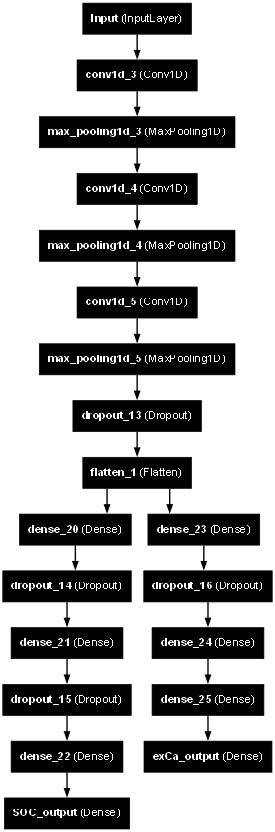

In [32]:
import keras
keras.utils.plot_model(cnn1d_mt, "cnn1d_mt.png", show_shapes=False, show_layer_names=True, dpi=50, rankdir="TB")  # TB ou rankidir="LR"     


In [33]:
cnn1d_mt.compile(optimizer='Adam', 
             loss={
                   'SOC_output': rmse,
                   'exCa_output': rmse},
             metrics={
                 'SOC_output': ['r2_score'],
                 'exCa_output': ['r2_score']})

from tensorflow.keras.callbacks import EarlyStopping
# early stopping para o modelo multi-target

early_stopping = EarlyStopping(
    monitor='val_loss',    # prefixo "val_" para validação, caso contrario ele atua no treino (val_r2_score para o r2_score da validação por exemplo)
    mode='min',                # queremos minimizar o erro de validação
    patience=20,             # número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True,
    verbose=1)                  # para ver quando o callback aciona

historico_cnn1d_mt = cnn1d_mt.fit(XRFcal_prep, 
                    Ycal_dict, 
                    epochs=40, 
                    batch_size=20, # o batch_size é o numero de amostras que serão incorporadas no erro medio para atualizar os pesos do modelo. se = 10, a cada 10 amostras o modelo atualiza os pesos
                    callbacks=[early_stopping], # aplica o early stopping
                    validation_data=(XRFval_prep, Yval_dict),
                    verbose=1)  


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - SOC_output_loss: 15.4972 - SOC_output_r2_score: -7.5664 - exCa_output_loss: 3.7863 - exCa_output_r2_score: -3.8223 - loss: 19.2943 - val_SOC_output_loss: 6.2185 - val_SOC_output_r2_score: -0.8206 - val_exCa_output_loss: 1.6878 - val_exCa_output_r2_score: 0.2066 - val_loss: 7.4874
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - SOC_output_loss: 6.5556 - SOC_output_r2_score: -0.4155 - exCa_output_loss: 1.8238 - exCa_output_r2_score: 0.0322 - loss: 8.3831 - val_SOC_output_loss: 4.6102 - val_SOC_output_r2_score: 0.1175 - val_exCa_output_loss: 1.1105 - val_exCa_output_r2_score: 0.6829 - val_loss: 5.0807
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - SOC_output_loss: 5.9012 - SOC_output_r2_score: -0.1496 - exCa_output_loss: 1.3755 - exCa_output_r2_score: 0.4594 - loss: 7.2801 - val_SOC_output_loss: 4.1065 - val_SOC_output_r2_score: 0.2741 - val_exCa_output_loss: 0.9008 - val_exCa_output_r2_score: 0.7578 - val_loss: 4.5868
Epoch 

In [34]:
# transformando os resultados em dataframes
calres_cnn1d_mt = pd.DataFrame({
	'SOC': cnn1d_mt.predict(XRFcal_prep)[0].flatten(), # predição dos dados de calibração
	'exCa': cnn1d_mt.predict(XRFcal_prep)[1].flatten()
})
predres_cnn1d_mt = pd.DataFrame({
	'SOC': cnn1d_mt.predict(XRFval_prep)[0].flatten(),
	'exCa': cnn1d_mt.predict(XRFval_prep)[1].flatten()
})

# inserindo os dados de referência nos dataframes
# A função enumerate() em Python é usada para percorrer uma sequência (como uma lista, tupla, string, etc.) e, ao mesmo tempo, obter tanto o índice como o valor de cada elemento.
# Nesse caso ela extrai o índice e o nome da coluna do dataframe Ycal e Yval simultaneamente

for i, col in enumerate(Ycal.columns):
    calres_cnn1d_mt.insert(i * 2, f"Ref_{col}", Ycal[col])
    
for i, col in enumerate(Yval.columns):
    predres_cnn1d_mt.insert(i * 2, f"Ref_{col}", Yval[col])	

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [38]:
resumo_cnn1d_mt = {'Cal': pd.DataFrame(resumo_multitarget(calres_cnn1d_mt)),
           'Pred': pd.DataFrame(resumo_multitarget(predres_cnn1d_mt))}

In [39]:
#printando as metricas 
print("R2 Calibração:")
for key, value in resumo_cnn1d_mt['Cal']['R2'].items():
    print(f"{key}: {value}")

print("\nR2 Predição:")
for key, value in resumo_cnn1d_mt['Pred']['R2'].items():
    print(f"{key}: {value}")

print("\nRMSEC:")
for key, value in resumo_cnn1d_mt['Cal']['RMSE'].items():
    print(f"{key}: {value}")  

print("\nRMSEP:")
for key, value in resumo_cnn1d_mt['Pred']['RMSE'].items():
    print(f"{key}: {value}")  

print("\nRPIQ:")
for key, value in resumo_cnn1d_mt['Pred']['RPIQ'].items():
    print(f"{key}: {value}")  

R2 Calibração:
SOC: 0.7412823923211977
exCa: 0.8618607097137814

R2 Predição:
SOC: 0.640428528877537
exCa: 0.8836865659519866

RMSEC:
SOC: 2.7754114003650785
exCa: 0.7104140033156008

RMSEP:
SOC: 2.6122719993023233
exCa: 0.6456200992189218

RPIQ:
SOC: 2.4308341557448596
exCa: 4.631206499948397


In [40]:
# Organizando os dicionarios com as métricas de performance
resumo_mlp_mt['Completo'] = pd.concat([resumo_mlp_mt['Cal'], resumo_mlp_mt['Pred']], axis=0)
resumo_mlp_mt['Completo']['Grupo'] = ['Cal'] * len(resumo_mlp_mt['Cal']) + ['Pred'] * len(resumo_mlp_mt['Pred'])

resumo_cnn1d_mt['Completo'] = pd.concat([resumo_cnn1d_mt['Cal'], resumo_cnn1d_mt['Pred']], axis=0)
resumo_cnn1d_mt['Completo']['Grupo'] = ['Cal'] * len(resumo_cnn1d_mt['Cal']) + ['Pred'] * len(resumo_cnn1d_mt['Pred'])

In [42]:
# salvando os resultados
resumo_mlp_mt['Completo'].to_csv('resumo_mlp_mt.csv', sep=';', index=True) # salva o resumo do modelo mlp_mt
resumo_cnn1d_mt['Completo'].to_csv('resumo_cnn1d_mt.csv', sep=';', index=True) # salva o resumo do modelo cnn1d_mt
resumo_mlptf.to_csv('resumo_mlptf.csv', sep=';', index=True) # salva o resumo do modelo mlptf
resumo_cnn1d.to_csv('resumo_cnn1d.csv', sep=';', index=True) # salva o resumo do modelo cnn1d